In [1]:
import xgboost as xgb
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle

import sys
sys.path.insert(0, '/home/btannenw/Desktop/ML/dihiggsMLProject/')
from rectangularCuts.rectangularAnalyzer import sequentialOneDimAnalyzer


In [2]:
#*** 0. Rectangular Analysis

qcd_csv = pd.read_csv('../samples_500k/qcd_outputDataForLearning.csv')
hh_csv  = pd.read_csv('../samples_500k/dihiggs_outputDataForLearning.csv')

variableNames = ['hh_mass', 'h1_mass', 'h2_mass', 'deltaR(h1, h2)', 'deltaR(h1 jets)', 'deltaR(h2 jets)']

rectangularAnalysis = sequentialOneDimAnalyzer(hh_csv, qcd_csv, variableNames)
rectangularAnalysis.analyze()

Analying variables:  Index(['hh_mass', 'h1_mass', 'h2_mass', 'deltaR(h1, h2)', 'deltaR(h1 jets)',
       'deltaR(h2 jets)'],
      dtype='object')
*** 1. Best Single Cut variables evaluated with ['S/B', 'S/sqrt(B)', 'S/sqrt(S+B)']
*** 2. Get Dictionaries of significance-ordered best cuts using ['S/B', 'S/sqrt(B)', 'S/sqrt(S+B)']
*** 3. Get Dictionaries of significance-ordered best cuts using ['S/B', 'S/sqrt(B)', 'S/sqrt(S+B)']
========== Efficiency 0.8% , Using > =========
peakVal for hh_mass at 319
Cut of 143 < hh_mass < 495 yields nSig = 63267 and nBkg = 18134
peakVal for h1_mass at 102
Cut of 50 < h1_mass < 154 yields nSig = 63296 and nBkg = 13630
peakVal for h2_mass at 105
Cut of 57 < h2_mass < 153 yields nSig = 63208 and nBkg = 14520
Cut of > 2.2 on deltaR(h1, h2) yields nSig = 63464 and nBkg = 27286
Cut of > 0.95 on deltaR(h1 jets) yields nSig = 64175 and nBkg = 23784
Cut of > 1.1 on deltaR(h2 jets) yields nSig = 63304 and nBkg = 21224
========== Efficiency 0.85% , Using > ======

In [3]:
def makeEqualSamplesWithUserVariables(signal_raw, bkg_raw, userVariables, nEventsForXGB):
    """function to return 4 dataframes containing user-specified variables and number of events: 1 signal for training, 1 bkg for training, 1 signal for plotting, 1 bkg for plotting"""
    
    # *** 0. Reduce dataframes to only desired variables
    signal_reduced  = signal_raw[userVariables]
    bkg_reduced     = bkg_raw[userVariables]
    signal_labels   = signal_raw[ ['isSignal'] ]
    bkg_labels      = bkg_raw[ ['isSignal'] ]

    # *** 1. Take first nEventsForXGB events for passing to XGB 
    signal_reducedForXGB  = signal_reduced[:nEventsForXGB]
    bkg_reducedForXGB     = bkg_reduced[:nEventsForXGB]
    signal_labelsForXGB   = signal_labels[:nEventsForXGB]
    bkg_labelsForXGB      = bkg_labels[:nEventsForXGB]

    # *** 2. Combine bkg+signal for passing to XGB 
    all_reducedForXGB  = signal_reducedForXGB.append(bkg_reducedForXGB)
    all_labelsForXGB   = signal_labelsForXGB.append(bkg_labelsForXGB)

    
    # ** 3. Use additional events for unambiguous testing 
    signal_reducedForPlots  = signal_reduced[nEventsForXGB:len(bkg_reduced)]
    bkg_reducedForPlots     = bkg_reduced[nEventsForXGB:len(bkg_reduced)]
    signal_labelsForPlots   = signal_labels[nEventsForXGB:len(bkg_reduced)]
    bkg_labelsForPlots      = bkg_labels[nEventsForXGB:len(bkg_reduced)]

    # *** 4. Sanity check
    print(len(all_reducedForXGB), 'rows of data with ', len(all_labelsForXGB), 'labels [XGB]')
    print(len(signal_reducedForPlots), 'rows of signal data with ', len(bkg_labelsForPlots), 'rows of background [Plots]')

    
    return all_reducedForXGB, all_labelsForXGB, signal_reducedForPlots, signal_labelsForPlots, bkg_reducedForPlots, bkg_labelsForPlots

def plotBDTOutputAndTree(_model, _modelName, _signalData, _signalLabels, _bkgData, _bkgLabels, _savePlots=False):
    """make plots of BDT outputs for signal+background probabilities and tree plot"""
    
    # *** 1. Make some 1D histograms of signal decision outputs
    signal_DMatrix = xgb.DMatrix(_signalData, label=_signalLabels)
    preds_signal = _model.predict(signal_DMatrix)
    sig_pred_isBkg     = [x[0] for x in preds_signal]
    sig_pred_isSignal  = [x[1] for x in preds_signal]
    #plt.hist(preds_hh)

    # *** 2. Make some 1D histograms of background decision outputs
    bkg_DMatrix = xgb.DMatrix(_bkgData, label=_bkgLabels)
    preds_bkg = _model.predict(bkg_DMatrix)
    bkg_pred_isBkg    = [x[0] for x in preds_bkg]
    bkg_pred_isSignal = [x[1] for x in preds_bkg]
    #plt.hist(preds_qcd)

    # *** 3. Plot feature importance
    if(_savePlots):
        xgb.plot_importance(_model)
        _fig = plt.gcf()
        _scope    = _modelName.split(' ')[0].lower()
        _variable = 'featureImportance'
        _filename  = _scope + '_' + _variable
        _fig.savefig( _filename+'.png', bbox_inches='tight' )
    
    # *** 4. Make dict for plotting with borrowed functions
    _nBins = 40
    predictionResults = {'hh_pred_isSignal':sig_pred_isSignal, 'hh_pred_isBkg':sig_pred_isBkg, 'qcd_pred_isSignal':bkg_pred_isSignal, 'qcd_pred_isBkg':bkg_pred_isBkg,}
    compareManyHistograms( predictionResults, ['hh_pred_isSignal', 'qcd_pred_isSignal'], 2, 'Signal Prediction', 'BDT Score ({0})'.format(_modelName), 0, 1, _nBins, _savePlot=_savePlots )
    compareManyHistograms( predictionResults, ['hh_pred_isBkg', 'qcd_pred_isBkg'], 2, 'Bkg Prediction', 'BDT Score ({0})'.format(_modelName), 0, 1, _nBins, _savePlot=_savePlots )

    # *** 5. Make plot of 0th tree
    #xgb.plot_tree(_model,num_trees=0)
    #plt.gcf().set_size_inches(100, 67)
    #_fig = plt.gcf()
    #plt.show()
    
    #if(_savePlots):
    #    _variable = 'firstTrainedDecisionTree'
    #    _filename  = _scope + '_' + _variable
    #    _fig.savefig( _filename+'.png' )
        
    # *** 6. restore figure defaults
    plt.rcParams['figure.figsize'] = [6.4, 4.8]

    
    return



def compareManyHistograms( _dict, _labels, _nPlot, _title, _xtitle, _xMin, _xMax, _nBins, _normed=False, _savePlot=False):
       
    if len(_dict.keys()) < len(_labels):
        print ("!!! Unequal number of arrays and labels. Learn to count better.")
        return 0
    
    plt.figure(_nPlot)
    if _normed:
        plt.title(_title + ' (Normalized)')
    else:
        plt.title(_title)
    plt.xlabel(_xtitle)
    plt.ylabel('N_events')
    _bins = np.linspace(_xMin, _xMax, _nBins)
   
    y_max = 0
    for iLabel in _labels:
        plt.hist(_dict[iLabel], _bins, alpha=0.5, density=_normed, label= iLabel+' Events')
        
        # get values of histgoram to find greatest y
        #_y, _x, _ = plt.hist(_dict[iLabel])
        #if (_y.max() > y_max):
        #    y_max = _y.max()
    
    # set max y-value of histogram so there's room for legend
    axes = plt.gca()
    axes.set_ylim([0,11000])
    #plt.ylim([0,1.2*y_max])
    
    #draw legend
    plt.legend(loc='upper left')
    #plt.text(.1, .1, s1)
    
    # store figure copy for later saving
    fig = plt.gcf()
    
    # draw interactively
    plt.show()
    
    #save an image file
    if(_savePlot):
        _scope    = _title.split(' ')[0].lower()
        _variable = _xtitle.lstrip('Jet Pair').replace(' ','').replace('[GeV]','').replace('(','_').replace(')','')
        _filename  = _scope + '_' + _variable
        if _normed:
            _filename = _filename + '_norm'
        fig.savefig( _filename+'.png', bbox_inches='tight' )
    
    
    return

20000 rows of data with  20000 labels [XGB]
19176 rows of signal data with  19176 rows of background [Plots]


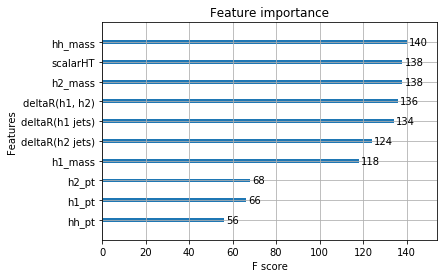

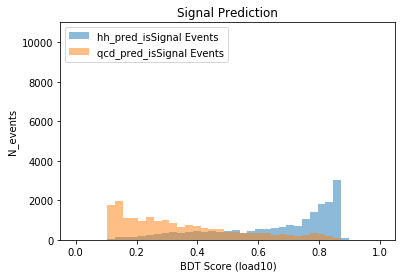

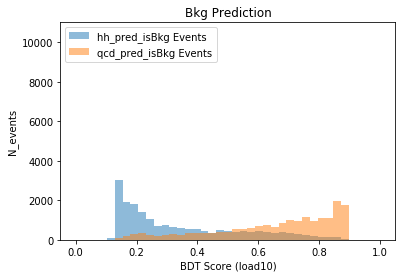

In [4]:
#*** 1. Import BDT model and check stuff
# *** 0. Import Dataset
qcd_raw = pd.read_csv('../samples_500k/qcd_outputDataForLearning.csv')
qcd_raw['isSignal'] = 0
hh_raw = pd.read_csv('../samples_500k/dihiggs_outputDataForLearning.csv')
hh_raw['isSignal'] = 1


# *** 5. Make mix of dihiggs and QCD for top-10 optimal variables
nEventsToTrain = 10000
variables_top10 = ['deltaR(h1, h2)', 'deltaR(h1 jets)', 'deltaR(h2 jets)', 'hh_mass', 'h1_mass', 'h2_mass','hh_pt', 'h1_pt', 'h2_pt', 'scalarHT']
top10_data, top10_labels, hh_top10_data, hh_top10_labels, qcd_top10_data, qcd_top10_labels = makeEqualSamplesWithUserVariables(hh_raw, qcd_raw, variables_top10, nEventsToTrain) 
load_top10 = pickle.load(open('model.top10.pkl', 'rb'))
plotBDTOutputAndTree(load_top10, 'load10', hh_top10_data, hh_top10_labels, qcd_top10_data, qcd_top10_labels, _savePlots=True)

hh_DMatrix = xgb.DMatrix(hh_top10_data, label=hh_top10_labels)
preds_hh = load_top10.predict(hh_DMatrix)
qcd_DMatrix = xgb.DMatrix(qcd_top10_data, label=qcd_top10_labels)
preds_qcd = load_top10.predict(qcd_DMatrix)

hh_pred_isSignal   = [x[1] for x in preds_hh]
qcd_pred_isSignal  = [x[1] for x in preds_qcd]


In [29]:
def returnBestCutValue( _variable, _signal, _background, _method='S/sqrt(B)', _minBackground=500):
    """find best cut according to user-specified significance metric"""
    
    _bestSignificance = -1
    _bestCutValue = -1
    _massWidth = 30 #GeV
    _nTotalSignal =len(_signal) 
    _nTotalBackground =len(_background) 
    _cuts = []
    _sortedSignal = np.sort(_signal )
    _sortedBackground = np.sort(_background )

    print(_nTotalSignal, _nTotalBackground)
    _minVal = min( min(_sortedSignal), min(_sortedBackground) )
    _maxVal = max( max(_sortedSignal), max(_sortedBackground) )
    
    if 'mass' in _variable:
        _stepSize = 0.05 if 'mass' not in _variable else 5
        _cuts = list(range(_minVal, _maxVal, _stepSize))
    else:
        _cuts = np.linspace(_minVal, _maxVal, 100)
    
    #print(_minVal, _maxVal)

    for iCutValue in _cuts:
        _nSignal = sum( value > iCutValue for value in _signal)
        _nBackground = sum( value > iCutValue for value in _background)
        
        # safety check to avoid division by 0
        if _nBackground < _minBackground: # 500 is semi-random choice.. it's where one series started to oscillate
            #print("continued on {0}".format(iCutValue))
            continue
        
        #if _method == 'S/sqrt(B)':
        #    print(_nSignal, _nBackground, iCutValue, (_nSignal / np.sqrt(_nBackground)), (_nSignal / np.sqrt(_nSignal + _nBackground)))
        
        if _method == 'S/B' and (_nSignal / _nBackground) > _bestSignificance:
            _bestSignificance = (_nSignal / _nBackground)
            _bestCutValue = iCutValue
        elif _method == 'S/sqrt(B)' and (_nSignal / np.sqrt(_nBackground)) > _bestSignificance:
            _bestSignificance = (_nSignal / np.sqrt(_nBackground))
            _bestCutValue = iCutValue
        elif _method == 'S/sqrt(S+B)' and (_nSignal / np.sqrt(_nSignal + _nBackground)) > _bestSignificance:
            _bestSignificance = (_nSignal / np.sqrt(_nSignal + _nBackground))
            _bestCutValue = iCutValue
                
        #print(iCutValue, _nSignal, _nBackground, (_nSignal / np.sqrt(_nBackground)))

    _nSignal = sum( value > _bestCutValue for value in _signal)
    _nBackground = sum( value > _bestCutValue for value in _background)
    #print(_nSignal, _nBackground, _nSignal/np.sqrt(_nBackground), _bestCutValue)
    print('nSig = {0} , nBkg = {1} with significance = {2} for BDT score > {3}'.format(_nSignal, _nBackground, _nSignal/np.sqrt(_nBackground), _bestCutValue) )
          
    return _bestSignificance, _bestCutValue


In [63]:
# *** 2. Get best cut value for BDT assuming some minimal amount of signal
returnBestCutValue('BDT', hh_pred_isSignal.copy(), qcd_pred_isSignal.copy(), _minBackground=400)

19176 19176
nSig = 6029 , nBkg = 421 with significance = 293.8354808157505 for BDT score > 0.8085214882486997


(293.8354808157505, 0.8085214882486997)

In [68]:
# *** 3. Get signifiance for any user-specified BDT score cut value
cut = 0.811
_nSignal = sum( value > cut for value in hh_pred_isSignal)
_nBackground = sum( value > cut for value in qcd_pred_isSignal)

print('nSig = {0} , nBkg = {1} with significance = {2} for BDT score > {3}'.format(_nSignal, _nBackground, _nSignal/np.sqrt(_nBackground), cut) )

nSig = 5977 , nBkg = 411 with significance = 294.82366786575994 for BDT score > 0.811


In [32]:
# *** 4. Use previously calculated const. efficiency cuts on testing data from BDT
cuts = rectangularAnalysis.dictOfCutsByEfficiency
rectangularAnalysis.setReducedData(hh_top10_data, qcd_top10_data)
rectangularAnalysis.calculateYieldsAfterCuts(0.90) 
rectangularAnalysis.calculateYieldsAfterCuts(0.85) 
rectangularAnalysis.calculateYieldsAfterCuts(0.80) 


iteration 3, signal has 19176 rows
iteration 3, background has 19176 rows
Iteration 3 chose variable hh_mass with N_signal = 17300 (17300.0) and N_background = 14746 (14746)
Iteration 2 chose variable h2_mass with N_signal = 16082 (16082.0) and N_background = 12228 (12228)
iteration 1, signal has 16082 rows
iteration 1, background has 12228 rows
Iteration 1 chose variable h1_mass with N_signal = 15566 (15566.0) and N_background = 10536 (10536)
S/sqrt(B) = 151.65
iteration 3, signal has 19176 rows
iteration 3, background has 19176 rows
Iteration 3 chose variable deltaR(h1, h2) with N_signal = 17427 (17427.0) and N_background = 18640 (18640)
Iteration 2 chose variable deltaR(h2 jets) with N_signal = 15668 (15668.0) and N_background = 14829 (14829)
iteration 1, signal has 15668 rows
iteration 1, background has 14829 rows
Iteration 1 chose variable deltaR(h1 jets) with N_signal = 14777 (14777.0) and N_background = 13656 (13656)
S/sqrt(B) = 126.45
iteration 6, signal has 19176 rows
iteratio

In [71]:
295./174

1.6954022988505748